# Importing Libraries and Pre-Processing Data

In [ ]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('/kaggle/input/datasss/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = 15000)) 
df = pa.Table.from_batches([first_ten_rows]).to_pandas() 


pf = ParquetFile('/kaggle/input/datasss/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = 1000)) 
df1 = pa.Table.from_batches([first_ten_rows]).to_pandas() 

pf = ParquetFile('/kaggle/input/datasss/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = 1000)) 
df2 = pa.Table.from_batches([first_ten_rows]).to_pandas() 
df = pd.concat([df, df1, df2])

test_df = df.tail(3400)  # Last 3400 rows as test set
train_df = df.head(len(df) - 3400)  # Rest as training set

# Print the shapes of the training and test sets
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Formatting Data into model format

In [2]:
X_train=[]
for data in train_df['X_jets']:
    val = np.zeros((125,125,3))
    val[:,:,0]= list(data[0])
    val[:,:,1]= list(data[1])
    val[:,:,2]= list(data[2])
    X_train.append([np.copy(val)])
X_train = [x[0] for x in X_train]
X_train = np.array(X_train)

X_test=[]
for data in test_df['X_jets']:
    val = np.zeros((125,125,3))
    val[:,:,0]= list(data[0])
    val[:,:,1]= list(data[1])
    val[:,:,2]= list(data[2])
    X_test.append([np.copy(val)])
X_test = [x[0] for x in X_test]
X_test = np.array(X_test)
print(X_train.shape,X_test.shape)

(13600, 125, 125, 3) (3400, 125, 125, 3)


# Data Visualization of the three channels

<Figure size 2000x2000 with 0 Axes>

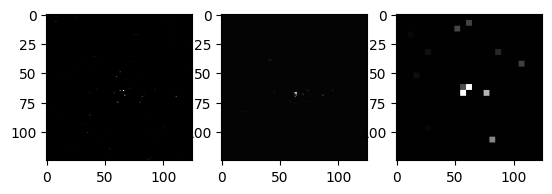

In [16]:
plt.figure(figsize=(20,20))
fig,ax = plt.subplots(1,3)
ax[0].imshow(X_train[0,:,:,0],cmap='gray')
ax[1].imshow(X_train[0,:,:,1],cmap='gray')
ax[2].imshow(X_train[0,:,:,2],cmap='gray')



# VGG-12 (didnt perform well)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam

input_shape = (125, 125,3)




# Instantiate the Sequential model
model = Sequential([
    Input((125,125,3)),
    # Block 1
    Conv2D(120, (3, 3)),
    Conv2D(120, (3, 3)),
    MaxPooling2D((2, 2)),
    # Block 2
    Conv2D(80, (3, 3)),
    Conv2D(80, (3, 3)),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(60, (3, 3)),
    Conv2D(60, (3, 3)),
    Conv2D(60, (3, 3)),

    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3)),
    Conv2D(32, (3, 3)),
    Conv2D(32, (3, 3)),

    MaxPooling2D((2, 2)),
    # FC layers
    Flatten(),
    Dense(50, activation='relu'),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


2024-03-31 14:59:10.407995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 14:59:10.408111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 14:59:10.527288: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
model.fit(X_train,train_df['y'],epochs=20,validation_data=(X_test,test_df['y']))

Epoch 1/20


2024-03-31 15:00:22.815116: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[120,120,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,120,123,123]{3,2,1,0}, f32[32,120,121,121]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-31 15:00:24.144481: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.329464521s
Trying algorithm eng0{} for conv (f32[120,120,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,120,123,123]{3,2,1,0}, f32[32,120,121,121]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-31 15:00:25.892155: E external/local_xla/xla/se

  3/425 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.4809 - loss: 0.7359 

I0000 00:00:1711897231.467212     208 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


425/425 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.6017 - loss: 0.6769 - val_accuracy: 0.5029 - val_loss: 0.7268
Epoch 2/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6261 - loss: 0.6769 - val_accuracy: 0.6774 - val_loss: 0.6072
Epoch 3/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6659 - loss: 0.6268 - val_accuracy: 0.6771 - val_loss: 0.6284
Epoch 4/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6672 - loss: 0.6282 - val_accuracy: 0.6612 - val_loss: 0.6351
Epoch 5/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6557 - loss: 0.6491 - val_accuracy: 0.6938 - val_loss: 0.5960
Epoch 6/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6673 - loss: 0.6279 - val_accuracy: 0.7076 - val_loss: 0.5905
Epoch 7/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.7019 - loss: 0.5881 - val_accuracy: 0.6676 - val_loss: 0.6281
Epoch 8/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.6697 - loss: 0.6210 - val_accurac

# EfficientNet B0 Used

In [4]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(125, 125, 3))
x = tf.keras.layers.Dropout(0.7)(base_model.output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

# Construct the new model
model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,train_df['y'],epochs=6,validation_data=(X_test,test_df['y']))

Epoch 1/6
425/425 ━━━━━━━━━━━━━━━━━━━━ 114s 81ms/step - accuracy: 0.6328 - loss: 0.6823 - val_accuracy: 0.5100 - val_loss: 0.7316
Epoch 2/6
425/425 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.6793 - loss: 0.6147 - val_accuracy: 0.5215 - val_loss: 0.9568
Epoch 3/6
425/425 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.7118 - loss: 0.5809 - val_accuracy: 0.5453 - val_loss: 0.7581
Epoch 4/6
425/425 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.7162 - loss: 0.5672 - val_accuracy: 0.6929 - val_loss: 0.6025
Epoch 5/6
425/425 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.7342 - loss: 0.5504 - val_accuracy: 0.5224 - val_loss: 0.9293
Epoch 6/6
425/425 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.7356 - loss: 0.5523 - val_accuracy: 0.7038 - val_loss: 0.5800


In [6]:
model.save_weights('effnet1.weights.h5')


# ROC Curve

107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step


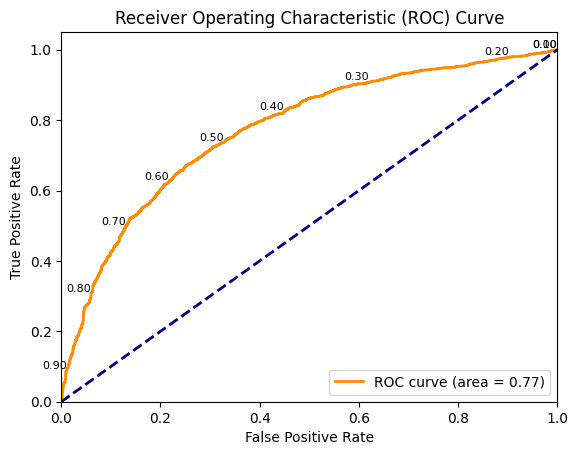

In [7]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_pred_prob is the predicted probabilities and y_actual is the actual labels
fpr, tpr, thresholds = roc_curve(test_df['y'], y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Adding thresholds to the plot
threshold_labels = np.linspace(0, 1, num=10, endpoint=False)
for threshold in threshold_labels:
    idx = np.argmin(np.abs(thresholds - threshold))
    plt.text(fpr[idx], tpr[idx], f'{threshold:.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='right')

plt.show()



# Final Result

In [17]:
import os
os.chdir(r'/kaggle/working')

In [13]:
y_pred_c = y_pred>0.52
# Assuming y_pred and y_actual are arrays or lists containing predicted and actual values respectively
accuracy = accuracy_score(test_df['y'], y_pred_c)
print("Accuracy:", accuracy)

Accuracy: 0.7073529411764706
